In [23]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

from triplet_dataset_loader import *
from TL_class import SiameseTripletModel
from TL_siamese_network import generate_siamese_triplet_network

In [5]:
database_path = "../databases/my-fruit-recognition"
split_ratio = (0.8, 0.2, 0)
image_size = (100,100)
batch_size = 32

auto = tf.data.AUTOTUNE

learning_rate = 0.0001
steps_per_epoch = 50
validation_steps = 10
epochs = 5

In [3]:
train_dataset, val_dataset, test_dataset = create_dataset(database_path, split_ratio, image_size, batch_size)
triplet_siamese_network = generate_siamese_triplet_network(image_size)
triplet_siamese_model = SiameseTripletModel(triplet_siamese_network)
triplet_siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
triplet_siamese_model.summary()

Model: "siamese_triplet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │    40,565,632 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,565,632 (154.75 MB)

 Trainable params: 25,907,712 (98.83 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

In [6]:
history = triplet_siamese_model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.2787 - loss: 0.5488 - val_accuracy: 0.3094 - val_loss: 0.3954
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.2625 - loss: 0.4007 - val_accuracy: 0.2781 - val_loss: 0.3685
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.2492 - loss: 0.3953 - val_accuracy: 0.2781 - val_loss: 0.3624
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.2632 - loss: 0.3681 - val_accuracy: 0.3187 - val_loss: 0.3512
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.3418 - loss: 0.3541 - val_accuracy: 0.3344 - val_loss: 0.3430


In [11]:
embedding_model = triplet_siamese_network.get_layer("Embedding")

In [19]:
import numpy as np

#funkcje operujące na wektorach zwracające spośród listy wektorów
#wektor najbliższy do wektora podanego w parametrach wywołania funkcji

def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

def top1_accuracy(vector_anchor, list_of_vectors):
    closest_vec = None
    min_distance = float('inf')
    for vector in list_of_vectors:
        distance = euclidean_distance(vector_anchor, vector)
        if distance < min_distance:
            min_distance = distance
            closest_vec = vector
    return closest_vec

def top3_accuracy(vector_anchor, list_of_vectors):
    # Oblicz odległości od wektora kotwicy dla wszystkich wektorów w liście
    distances = [(vector, euclidean_distance(vector_anchor, vector)) for vector in list_of_vectors]
    
    # Posortuj według odległości rosnąco
    distances.sort(key=lambda x: x[1])
    
    # Zwroc pierwsze trzy elementy (najbliższe wektory)
    closest_3_vecs = [item[0] for item in distances[:3]]
    return closest_3_vecs

In [12]:
# Ścieżka do głównego folderu zbioru testowego
base_test_folder = "../databases/my-fruit-recognition"

# Lista ścieżek do pierwszego zdjęcia w każdym z podfolderów
first_image_paths = []

# Przeglądanie każdego folderu w zbiorze testowym
for root, dirs, files in os.walk(base_test_folder):
    # Sprawdź, czy bieżący folder ma jakieś pliki
    files = [f for f in files if f != ".DS_Store"]
    if files:
        # Sortowanie plików w celu uzyskania pierwszego według nazwy
        files_sorted = sorted(files)
        # Dodaj pełną ścieżkę do pierwszego pliku
        first_image_path = os.path.join(root, files_sorted[0])
        first_image_paths.append(first_image_path)

# Wyświetlenie listy ścieżek
for path in first_image_paths:
    print(path)

../databases/my-fruit-recognition/Apple/Apple E/Apple E001.png
../databases/my-fruit-recognition/Apple/Apple B/102red applee00901102.png
../databases/my-fruit-recognition/Apple/Apple C/Apple Ce00151.png
../databases/my-fruit-recognition/Apple/Apple D/Apple De00001.png
../databases/my-fruit-recognition/Apple/Apple A/Apple 1.png
../databases/my-fruit-recognition/Apple/Apple F/Apple F _0_1.png
../databases/my-fruit-recognition/Pitaya/Pitaya001.png
../databases/my-fruit-recognition/Pear/Pear 1.png
../databases/my-fruit-recognition/Pomegranate/Pomegranet001.png
../databases/my-fruit-recognition/Tomatoes/Tamotoes001.png
../databases/my-fruit-recognition/Kiwi/kiwi A/Kiwi A001.png
../databases/my-fruit-recognition/Kiwi/Kiwi C/Kiwi C001.png
../databases/my-fruit-recognition/Kiwi/Kiwi B/Kiwi B001.png
../databases/my-fruit-recognition/Guava/guava B/Guava1.png
../databases/my-fruit-recognition/Guava/guava A/cene00001.png
../databases/my-fruit-recognition/Plum/Plum。1.png
../databases/my-fruit-recog

In [16]:
mapF = MapFunction(image_size)

first_images = [mapF.decode_and_resize(image_path) for image_path in first_image_paths]

first_images = tf.convert_to_tensor(first_images)

first_embeddings = embedding_model.predict(first_images)

print(first_embeddings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
[[-0.05468055  1.9519956  -0.88604414 ...  0.10767438  0.19534934
  -0.18009481]
 [-0.12389862  1.931794   -0.8859748  ...  0.15636054  0.26306725
  -0.16607928]
 [-0.07607316  1.9642912  -0.8799786  ...  0.11600122  0.22265464
  -0.20039614]
 ...
 [-0.15574563  2.1266568  -0.8197082  ...  0.1767489   0.20625481
  -0.251599  ]
 [-0.03994416  1.7869655  -0.8041659  ...  0.12052877  0.26786503
  -0.13167994]
 [-0.097887    2.027503   -0.89558494 ...  0.16842234  0.2732119
  -0.29118526]]


In [33]:
# Przygotuj obraz zapytania
query_image_path = "../databases/my-fruit-recognition/Banana/Banana01.png"
query_image = mapF.decode_and_resize(query_image_path)

query_image = tf.expand_dims(query_image, axis=0)  # Add batch dimension
query_embedding = embedding_model.predict(query_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [34]:
closest_vector = top1_accuracy(query_embedding, first_embeddings)

closest_image_index = np.argmin([euclidean_distance(closest_vector, vec) for vec in first_embeddings])

print("Najbliższy obraz:", first_image_paths[closest_image_index])

Najbliższy obraz: ../databases/my-fruit-recognition/Banana/71Banana02034.png


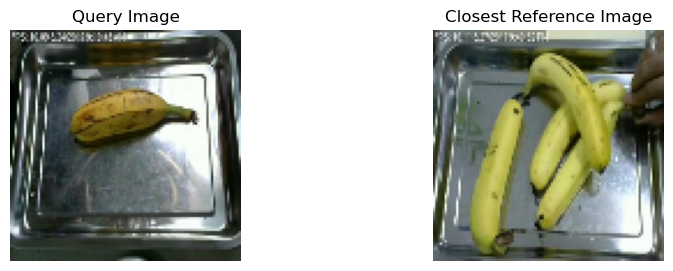

In [35]:
closest_image_path = first_image_paths[closest_image_index]


query_image_decoded = mapF.decode_and_resize(query_image_path)
closest_image_decoded = mapF.decode_and_resize(closest_image_path)

query_image_np = query_image_decoded.numpy()
closest_image_np = closest_image_decoded.numpy()


# Plot the images
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.imshow(query_image_np)
plt.title('Query Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(closest_image_np)
plt.title('Closest Reference Image')
plt.axis('off')

plt.show()

Trzy najbliższe obrazy: ['../databases/my-fruit-recognition/Banana/71Banana02034.png', '../databases/my-fruit-recognition/Mango/Mango001.png', '../databases/my-fruit-recognition/Apple/Apple F/Apple F _0_1.png']


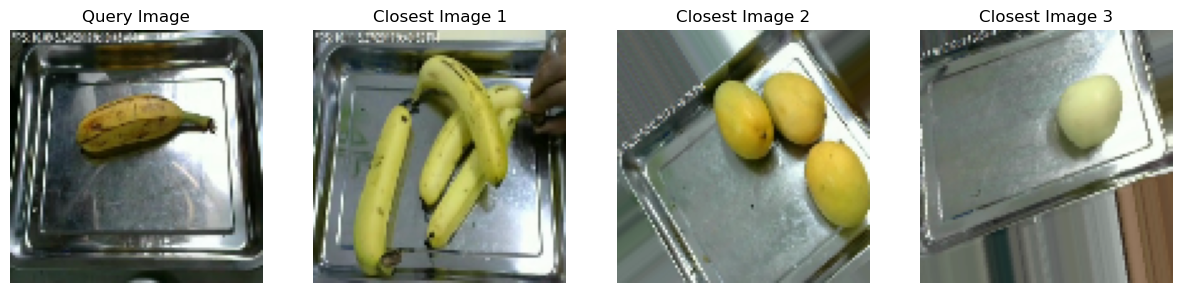

In [36]:
closest_3_vectors = top3_accuracy(query_embedding, first_embeddings)

closest_3_indices = [np.argmin([euclidean_distance(vec, ref_vec) for ref_vec in first_embeddings]) for vec in closest_3_vectors]

print("Trzy najbliższe obrazy:", [first_image_paths[i] for i in closest_3_indices])

closest_image_paths = [first_image_paths[i] for i in closest_3_indices]

# Load and decode images for plotting
query_image_decoded = mapF.decode_and_resize(query_image_path)
closest_images_decoded = [mapF.decode_and_resize(image_path) for image_path in closest_image_paths]

# Convert tensors to numpy arrays
query_image_np = query_image_decoded.numpy()
closest_images_np = [image.numpy() for image in closest_images_decoded]

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(query_image_np)
plt.title('Query Image')
plt.axis('off')

for i, img in enumerate(closest_images_np):
    plt.subplot(1, 4, i + 2)
    plt.imshow(img)
    plt.title(f'Closest Image {i + 1}')
    plt.axis('off')

plt.show()